# Première version de l'autoencodeur simple sur le petit jeu de données Olivetti faces

In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, random_split

## Chargement du dataset et formatage des données

In [4]:
# Charger le dataset Olivetti Faces
dataset = fetch_olivetti_faces(shuffle=True, random_state=42)
X, y = dataset.images, dataset.target  # X contient les images, y contient les labels


# Conversion des données en tenseurs
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.long)

# Création d'un dataset PyTorch
tensor_dataset = TensorDataset(X_tensor, y_tensor)

# Séparation en train/test (80% entraînement, 20% test)
train_size = int(0.8 * len(tensor_dataset))
test_size = len(tensor_dataset) - train_size
train_dataset, test_dataset = random_split(tensor_dataset, [train_size, test_size])

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Création des DataLoaders
loader = DataLoader(tensor_dataset, batch_size=32, shuffle=True)

## Autoencodeur
réseau de neurones convolutif

In [69]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # (batch, 16, 32, 32)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (batch, 32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (batch, 64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout2d(p=0.2)
        )
        # Décodeur
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 16, 32, 32)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            #nn.Dropout2d(p=0.2),
            
            
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 1, 64, 64)
            nn.Sigmoid()
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

    def encode(self, x):
        """Extraction espace latent"""
        return self.encoder(x)


In [71]:
model = Autoencoder()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

## Entrainement du modèle

Epoch 1/20, Loss: 0.028839
Epoch 2/20, Loss: 0.018869
Epoch 3/20, Loss: 0.013321
Epoch 4/20, Loss: 0.010511
Epoch 5/20, Loss: 0.007248
Epoch 6/20, Loss: 0.004582
Epoch 7/20, Loss: 0.004765
Epoch 8/20, Loss: 0.003590
Epoch 9/20, Loss: 0.003567
Epoch 10/20, Loss: 0.003323
Epoch 11/20, Loss: 0.002993
Epoch 12/20, Loss: 0.003149
Epoch 13/20, Loss: 0.002787
Epoch 14/20, Loss: 0.002924
Epoch 15/20, Loss: 0.002861
Epoch 16/20, Loss: 0.002789
Epoch 17/20, Loss: 0.002174
Epoch 18/20, Loss: 0.003257
Epoch 19/20, Loss: 0.002266
Epoch 20/20, Loss: 0.002361


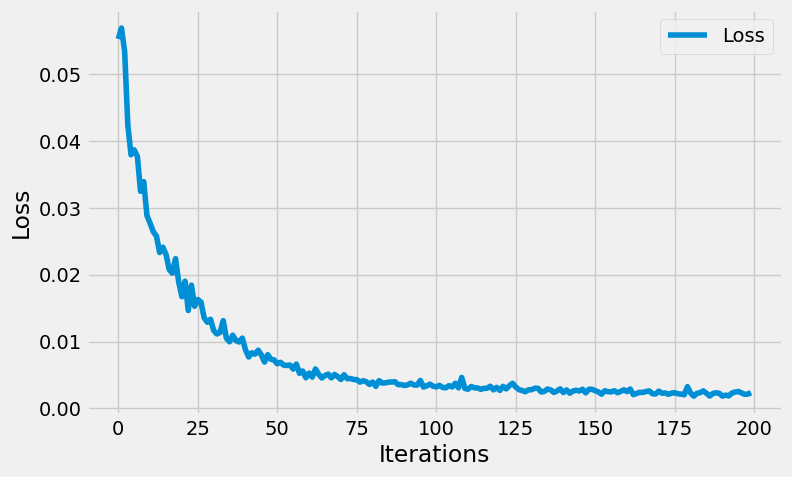

In [74]:
epochs = 20
outputs = []
losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for images, _ in train_loader:
        images = images.to(device)
        
        reconstructed = model(images)
        #loss = loss_function(reconstructed, images)
        loss = loss_function(reconstructed, images)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, images, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation du modèle

Test Loss: 0.001891


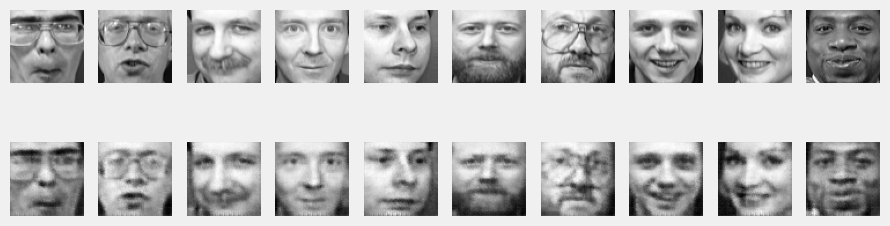

In [77]:
model.eval()
test_loss = 0

with torch.no_grad():  # Pas besoin de calculer les gradients
    for images, _ in test_loader:
        images = images.to(device)
        reconstructed = model(images)
        
        loss = loss_function(reconstructed, images)  # Ex: nn.MSELoss()
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.6f}")

dataiter = iter(test_loader)
images, _ = next(dataiter)

images = images.to(device)
reconstructed = model(images)

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 3))
for i in range(10):
    axes[0, i].imshow(images[i].cpu().detach().numpy().reshape(64, 64), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed[i].cpu().detach().numpy().reshape(64, 64), cmap='gray')
    axes[1, i].axis('off')
plt.show()

# Test avec modification espace latent (1 seul) :

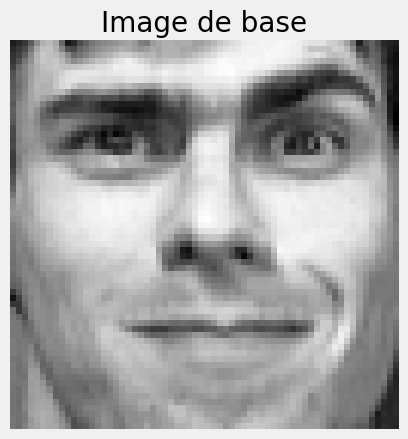

Vecteur latent extrait associé à l'image : tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.3747, 2.0888, 3.1004,  ..., 0.1462, 0.1873, 0.0000],
          [0.1882, 0.0000, 0.0000,  ..., 0.3374, 0.0000, 0.6563],
          ...,
          [0.4349, 0.0000, 0.0000,  ..., 0.2540, 0.0000, 0.1406],
          [0.2868, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7959],
          [0.6593, 0.0000, 0.2431,  ..., 0.0000, 0.4326, 0.5693]],

         [[0.0000, 0.3323, 0.0000,  ..., 0.0000, 0.0000, 0.2657],
          [0.0000, 0.7799, 0.0342,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0206, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.5478,  ..., 0.0000, 0.1266, 0.1391],
          [0.2177, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.6473],
          [0.0000, 0.0000, 0.0000,  ..., 0.0386, 0.0000, 0.0000]],

         [[2.2368, 1.1397, 0.5448,  ..., 0.0000, 0.0000, 1.4719],
          [0.7974, 0.9150, 1.1434,  ..., 0.9818, 0.7382, 0.5420],

In [120]:
# Extraction du vecteur latent

# Récupérer une image
data_iter = iter(train_loader)  # train_loader l'entrainement
image, _ = next(data_iter)  # Prendre un batch d'images (et ignorer les labels s'il y en a)

# Sélectionner une seule image du batch
image_2d = image[0].squeeze().cpu().numpy().reshape(64, 64)  # Garder une version 2D pour affichage

# Afficher l'image originale
plt.imshow(image_2d, cmap="gray")
#plt.imshow(images[0].cpu().detach().numpy().reshape(64, 64), cmap='gray')
plt.axis("off")  # Supprime les axes pour une meilleure visibilité
plt.title("Image de base")
plt.show()

# Envoyer l'image sur le bon device
image = image[0].unsqueeze(0).to(device)  # Ajouter une dimension batch

# Passer dans l'encodeur pour obtenir le vecteur latent
model.eval()
with torch.no_grad():
    latent_vector = model.encoder(image)  # Pas besoin de .view()

print("Vecteur latent extrait associé à l'image :", latent_vector)


In [122]:
print(len(latent_vector))
print(type(latent_vector))
print(len(latent_vector[0]))

1
<class 'torch.Tensor'>
64


# Modification du vecteur latent seul :

In [133]:
# Modification aléatoire du vecteur latent :

modification = torch.randn_like(latent_vector) * 0.5  # Petite perturbation aléatoire pour tests
latent_modified = latent_vector + modification

#print("Vecteur latent initial :", latent_vector)
#print("Vecteur latent modifié :", latent_modified)


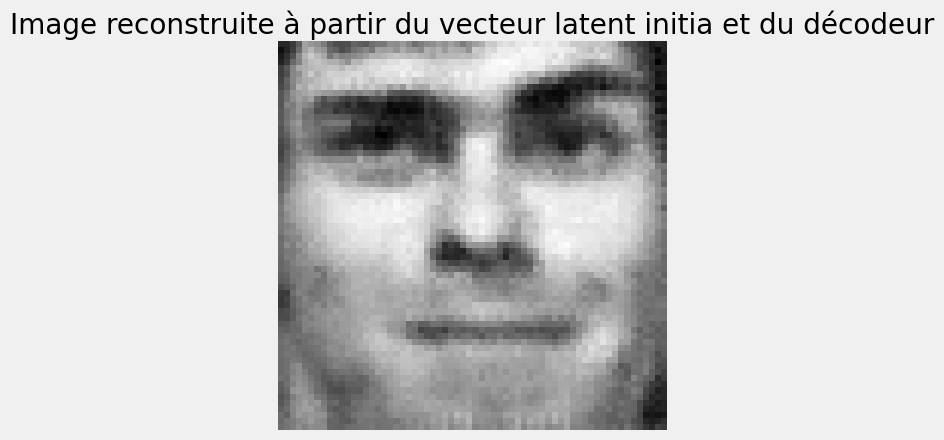

In [135]:
# Reconstruction de l'image (à partir du vecteur latent de base):

with torch.no_grad():
    reconstructed_image = model.decoder(latent_vector)  # Reconstruction

reconstructed_image = reconstructed_image.view(64, 64).cpu().numpy()  # Remettre en forme

plt.imshow(reconstructed_image, cmap="gray")
plt.title("Image reconstruite à partir du vecteur latent initia et du décodeur")
plt.axis("off")
plt.show()


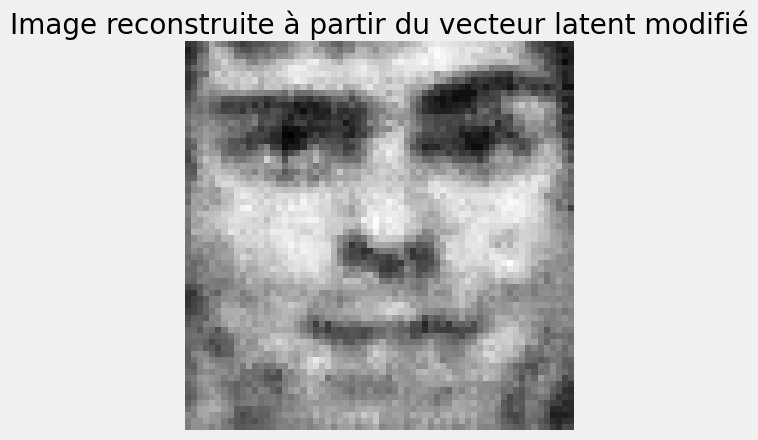

In [151]:
# Reconstruction de l'image (à partir du vecteur latent modifié):

with torch.no_grad():
    reconstructed_image = model.decoder(latent_modified)  # Reconstruction

reconstructed_image = reconstructed_image.view(64, 64).cpu().numpy()  # Remettre en forme

plt.imshow(reconstructed_image, cmap="gray")
plt.title("Image reconstruite à partir du vecteur latent modifié")
plt.axis("off")
plt.show()


# Modification vecteur latent par fusion de deux images (deux vecteurs latents):

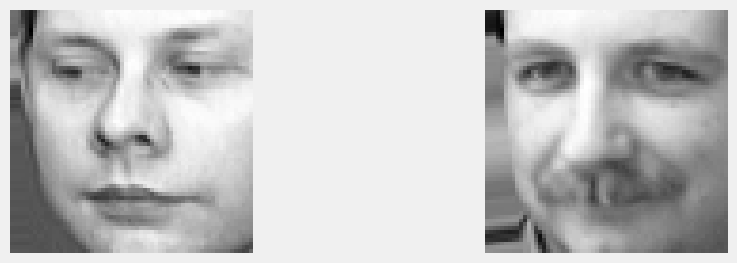

In [169]:
# Extraction de plusieurs vecteurs latents (pour tests avec deux images) :

# Récupérer une image
data_iter = iter(train_loader)  # train_loader l'entrainement
image, _ = next(data_iter)  # Prendre un batch d'images (et ignorer les labels s'il y en a)

# Sélectionner une seule image du batch
image_2d1 = image[0].squeeze().cpu().numpy().reshape(64, 64)  # Garder une version 2D pour affichage
image_2d2 = image[1].squeeze().cpu().numpy().reshape(64, 64)  # Garder une version 2D pour affichage

stored_images = []
stored_images.append(image_2d1)
stored_images.append(image_2d2)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
for i in range(2):
    axes[i].imshow(stored_images[i], cmap='gray')
    axes[i].axis('off')
#plt.title("Images de base")
plt.show()


# Envoyer l'image sur le bon device
image1 = image[0].unsqueeze(0).to(device)  # Ajouter une dimension batch
image2 = image[1].unsqueeze(0).to(device)  # Ajouter une dimension batch

# Passer dans l'encodeur pour obtenir le vecteur latent
model.eval()
with torch.no_grad():
    latent_vector1 = model.encoder(image1)  # Pas besoin de .view()
    latent_vector2 = model.encoder(image2)

#print("Vecteur latent extrait associé à l'image 1 :", latent_vector1)
#print("Vecteur latent extrait associé à l'image 2:", latent_vector2)


In [171]:
# Fusion des deux vecteurs latents :

latent_fused = (latent_vector1 + latent_vector2) / 2

#print("Premier vecteur latent initial :", latent_vector1)
#print("Deuxième vecteur latent initial :", latent_vector2)
#print("Vecteurs latents fusionnés :", latent_fused)


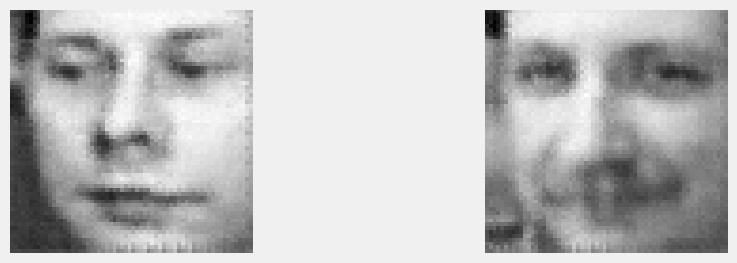

In [174]:
# Reconstruction des images (à partir des vecteurs latents initiaux):

with torch.no_grad():
    #reconstructed_image = model.decoder(latent_modified)  # Reconstruction
    reconstructed_image1 = model.decoder(latent_vector1)
    reconstructed_image2 = model.decoder(latent_vector2)

stored_reconstructed = []
reconstructed_image1 = reconstructed_image1.view(64, 64).cpu().numpy() 
reconstructed_image2 = reconstructed_image2.view(64, 64).cpu().numpy()  # Remettre en forme

stored_reconstructed.append(reconstructed_image1)
stored_reconstructed.append(reconstructed_image2)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

for i in range(2):
    axes[i].imshow(stored_reconstructed[i], cmap='gray')
    axes[i].axis('off')
#plt.title("Images de base")
plt.show()


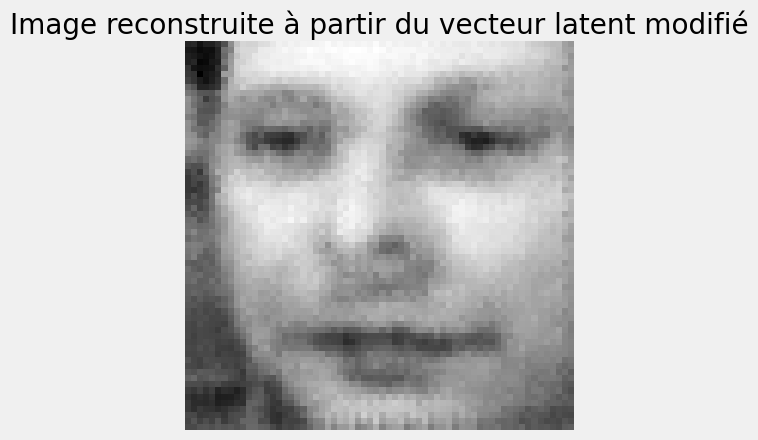

In [176]:
# Reconstruction de l'image (à partir du vecteur latent modifié):

with torch.no_grad():
    #reconstructed_image = model.decoder(latent_modified)  # Reconstruction
    reconstructed_image = model.decoder(latent_fused)  # Reconstruction

reconstructed_image = reconstructed_image.view(64, 64).cpu().numpy()  # Remettre en forme

plt.imshow(reconstructed_image, cmap="gray")
plt.title("Image reconstruite à partir du vecteur latent modifié")
plt.axis("off")
plt.show()


TDL : faire partie avec images similaires avec et sans lunettes (dans l'idée)  
--> prendre des vraies photos et les convertir en tensor ?  
sélectionner photos avec lunettes et celles sans et faire la soustraction des moyennes de chaque catégorie (faire attention aux biais H/F, etc)

# Tests 

In [182]:
# Tests transformation images en tensor torch
import torch
from torchvision import transforms
from PIL import Image

In [190]:
img = Image.open("./images_for_tests/homme_lunettes.jpg")
#img

In [188]:
convert_tensor = transforms.ToTensor()
convert_tensor(img)

tensor([[[0.8784, 0.8784, 0.8784,  ..., 0.9137, 0.9137, 0.9137],
         [0.8784, 0.8784, 0.8784,  ..., 0.9137, 0.9137, 0.9137],
         [0.8784, 0.8784, 0.8784,  ..., 0.9137, 0.9137, 0.9137],
         ...,
         [0.9529, 0.9529, 0.9529,  ..., 0.9725, 0.9686, 0.9686],
         [0.9608, 0.9608, 0.9608,  ..., 0.9686, 0.9647, 0.9647],
         [0.9569, 0.9608, 0.9608,  ..., 0.9725, 0.9686, 0.9686]],

        [[0.8784, 0.8784, 0.8784,  ..., 0.9137, 0.9137, 0.9137],
         [0.8784, 0.8784, 0.8784,  ..., 0.9137, 0.9137, 0.9137],
         [0.8784, 0.8784, 0.8784,  ..., 0.9137, 0.9137, 0.9137],
         ...,
         [0.9686, 0.9686, 0.9686,  ..., 0.9804, 0.9843, 0.9843],
         [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9686, 0.9686],
         [0.9647, 0.9686, 0.9686,  ..., 0.9765, 0.9725, 0.9725]],

        [[0.8784, 0.8784, 0.8784,  ..., 0.9137, 0.9137, 0.9137],
         [0.8784, 0.8784, 0.8784,  ..., 0.9137, 0.9137, 0.9137],
         [0.8784, 0.8784, 0.8784,  ..., 0.9137, 0.9137, 0.